# Анализ товарного асcортимента

# Материалы

[Презентация](https://github.com/zhbak/yandex_praktikum_projects/blob/main/Анализ%20товарного%20ассортимента/Презентация_анализ_товарного_асортимента.pdf)

[Дашборд](https://public.tableau.com/views/____ya_prak/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link)

**Цель** – предоставление рекомендаций покупателям по товарным предложениям.

**Задачи:**
- обзор данных;
- предобработка данных;
- исследовательский анализ данных;
- статистические гипотезы;
- составление презентации.


**Обзор данных:**
- вывод данных для обзора;
- рассмотрение типов значений в столбцах;
- определение пропущенных значений;
- осуществление поиска явных и неявных дубликатов.

**Предобработка данных:**
- переименование столбцов;
- заполнение или удаление пропущенных значений;
- изменение типов данных;
- удаление или замена дубликатов.

**Исследовательский анализ данных:**
- анализ полноты данных; 
- изучение распределения количества товаров по заказам и покупателям. 
- исключение выдающихся значений;
- категоризация товаров;
- анализ выручки каждой категории:
	- какие категории самые популярные;
	- какие категории приносят наибольшую выручку;
	- зависит ли цена заказа от количества товаров.
- составление характерных портретов пользователей:
	- какие товары покупают;
	- как часто;
	- сезонность и время совершения заказов.
    
**Статистические гипотезы:**
- Проверка сезонности доли товаров в популярной категории;
- Проверка сезонности средней выручки товаров в популярной категории;
- Проверка статистической значимости различия средней выручки заказов с одним товаром со средней выручки заказов, в которых товаров больше одного.

**Описание данных:**
- `date` — дата заказа;
- `customer_id` — идентификатор покупателя;
- `order_id` — идентификатор заказа;
- `product` — наименование товара;
- `quantity` — количество товара в заказе;
- `price` — цена товара.

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import pymorphy2
import math as mth
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from scipy import stats as st

In [2]:
# загрузка данных
try:
    logs = pd.read_csv(r'C:\Users\Zhbak\OneDrive\Образование\2022_Yandex_аналитик_данных\01_Проекты\13_Сборный_проект\ecommerce_dataset.csv')
except:
    import requests
    import json
    from urllib.parse import urlencode

    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    public_key = 'https://disk.yandex.ru/d/kJwc3szk7vzv_g'  # Необходимая ссылка на файл

    # Получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = json.loads(response.text)['href']

    logs = pd.read_csv(download_url, sep=',') 

## Обзор данных

In [3]:
# Функция обзора данных
def first_look(df):
    print('----------Первые 5 строк----------')
    display(df.head())
    print('\n')
    print('----------Тип данных----------')
    display(df.info())
    print('----------Пропуски в данных----------')
    df_isna = df.isna().sum()
    if df_isna.sum() > 0:
        print(df_isna)
    else: print('Пропусков нет')
    print()
    print('----------Количество явных дубликатов----------')
    print(df.duplicated().sum())

In [4]:
first_look(logs)

----------Первые 5 строк----------


,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0




----------Тип данных----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


None

----------Пропуски в данных----------
Пропусков нет

----------Количество явных дубликатов----------
0


- Все столбцы присутствуют;
- Необходимо обработать формат даты;
- В таблице 6737 логов.

## Предобработка данных

### Изменение типов данных 

In [5]:
# Приведение даты в читаемый формат
logs['date'] = pd.to_datetime(logs['date'], format='%Y%m%d%H')

### Явные дубликаты 

In [6]:
logs[['customer_id', 'date', 'order_id', 'product', 'quantity', 'price']].duplicated().sum()

0

Дубликатов не обнаружено.

### Неявные дубликаты 

#### Неявные дубликаты в названии продукта 

В поиске неявных дубликатов остановимся только на наименованиях продуктов. Посмотрим на список уникальных названий.

In [7]:
logs['product'].value_counts()[:20]

Рассада Кабачка сорт Зебра кассета 6 шт E6                              79
Рассада Кабачка сорт Золотинка кассета 6 шт E6                          78
Рассада Кабачка сорт Белогор кассета 6 шт E6                            77
Рассада Огурца сорт Каролина кассета 6 шт E6                            76
Пеларгония розебудная Red Pandora укорененный черенок                   76
Рассада Кабачка сорт Горный, кассета по 6шт                             76
Тагетис крупноцветковый рассада однолетних цветов в кассете по 10 шт    76
Рассада Огурец Фараон ячейки по 6 шт Е6                                 76
Рассада Кабачка сорт Аэронавт, кассета по 6шт                           76
Рассада Патиссона сорт НЛО Белый, кассета по 6шт                        75
Рассада Кабачка сорт Сосновский, кассета по 6шт                         75
Рассада Огурец Кристина ячейки по 6 шт Е6                               74
Рассада Патиссона сорт Диск, кассета по 6шт                             74
Сумка-тележка 2-х колесна

Обнаружено, что слово термокружка написано с латинской "T". Это нужно исправить. Также, часто в одних и тех же словах встречается разное написание буквы "ё". Её могут написать как "е".

Поищем слова с буквой "ё".

In [8]:
# устраним заглавные буквы
logs['product'] = logs['product'].str.lower()

In [9]:
# функция для составления списка со словами, где есть буква "ё"
def io_search(text, list_of_words_io):
    for word in text.split():
        if 'ё' in list(word):
            list_of_words_io.append(word)

In [10]:
# ищем
list_of_words_io = []
logs.apply(lambda x: io_search(x['product'], list_of_words_io), axis=1)
sorted(set(list_of_words_io))

['белый/чёрный',
 'зелёный/белый,',
 'ковёр',
 'конёк',
 'тёмно-коричневая',
 'тёмно-розовый',
 'чёрный',
 'щётка',
 'ёрш']

Нашлось 9 слов с буквой "ё". Составим словарь для замены, не забыв про термокружку.

In [11]:
dict_change = {
    'ёрш':'ерш',
    'щётка': 'щетка',
    'конёк': 'конек',
    'ковёр': 'ковер',
    'белый/чёрный': 'белый/черный',
    'зелёный/белый,': 'зеленый/белый,',
    'тёмно-коричневая':'темно-коричневая',
    'тёмно-розовый': 'темно-розовый',
    'чёрный': 'черный',
    'tермокружка': 'термокружка',
}

In [12]:
# функция для замены слов с буквой "ё" на основе словаря dict_change
def change(text):
    for word in text.split():
        if word in dict_change:
            text = text.replace(word, dict_change[word])
    return text

In [13]:
# применям функцию
logs['product'] = logs.apply(lambda x:change(x['product']), axis=1);

#### Проверка неявных дубликатов с исключением столбца date 

Также проверим дубликаты с исключением столбца даты.

In [14]:
logs[['customer_id', 'order_id', 'product', 'quantity', 'price']].duplicated().sum()

1864

Нашли 1864 дубликата.

In [15]:
logs_duplicated = logs[logs[['customer_id', 'order_id', 'product', 'quantity', 'price']].duplicated()]

Взглянем на их распределение по времени.

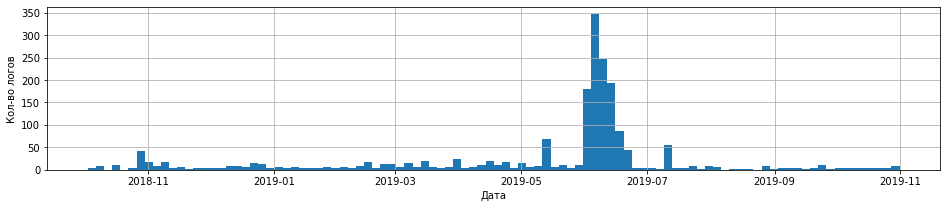

In [16]:
plt.figure(figsize=(16, 3))
logs_duplicated['date'].hist(bins=100)
plt.xlabel('Дата')
plt.ylabel('Кол-во логов');

Увеличение их количества наблюдается в июне. Посмотрим что там.

In [17]:
logs[(logs['date'] > '2019-06-01 00:00:00') & (logs['date'] < '2019-07-01 00:00:00')].sort_values(by='product')[0:50]

,date,customer_id,order_id,product,quantity,price
4578,2019-06-05 09:00:00,7d5d5657-5fdc-40d1-b7b6-bb04ede92b53,14848,аквилегия махровая тауэр смесь окрасок объем 1 л,1,97.0
4579,2019-06-05 09:00:00,7d5d5657-5fdc-40d1-b7b6-bb04ede92b53,14848,алиссум скальный желтый объем 1 л,1,105.0
4754,2019-06-07 08:00:00,6a86cc77-ef15-496f-b5d3-89005597ee5d,14856,алиссум скальный желтый объем 1 л,1,105.0
4729,2019-06-06 16:00:00,6a86cc77-ef15-496f-b5d3-89005597ee5d,14856,алиссум скальный желтый объем 1 л,1,105.0
4818,2019-06-07 21:00:00,4723417a-8c73-4502-9600-75187124fb5c,71638,антинакипин для утюгов ампулы 10 мл по 5 шт un...,1,164.0
4817,2019-06-07 17:00:00,4723417a-8c73-4502-9600-75187124fb5c,71638,антинакипин для утюгов ампулы 10 мл по 5 шт un...,1,164.0
5593,2019-06-26 08:00:00,193ab3dd-4bbf-4937-956d-410485230137,71803,антуриум тропик найт нидерланды 1 штука в упак...,1,262.0
5592,2019-06-26 07:00:00,193ab3dd-4bbf-4937-956d-410485230137,71803,антуриум тропик найт нидерланды 1 штука в упак...,1,262.0
4580,2019-06-05 09:00:00,7d5d5657-5fdc-40d1-b7b6-bb04ede92b53,14848,астра альпийская микс объем 1 л,1,97.0
4755,2019-06-07 08:00:00,6a86cc77-ef15-496f-b5d3-89005597ee5d,14856,бадан сердцелистный красная звезда красный объ...,1,150.0


Наблдается множество записей с одинаковыми наименованиями продуктов в количестве одной штуки в разное время, но сделанными одим покупателем, но в рамках одного заказа. Достаточно сложно сказать почему так произошло, но вот возможные причины:
1. Сбой в системе сбора данных;
2. Дозаказ покупателем в течение короткого срока (вопрос с какой целью);
3. Постепенное формирование заказа со стороны поставщика (зафисит от алгоритма записи в базу данных) и т.д.

На мой взгляд, оптимальным вариантом обработки дубликатов является их группировка по номеру покупателя, продукту, заказу с суммированием их количества, с выбором первой цены и даты первой записи.

In [18]:
logs = logs.groupby(['customer_id', 'order_id', 'product']).agg({'quantity' : 'sum',
                                                            'price': 'first',
                                                            'date': 'first'}).reset_index()

In [19]:
logs[['customer_id', 'order_id', 'product', 'quantity', 'price']].duplicated().sum()

0

Теперь неяных дубликатов нет.

## Исследовательский анализ данных 

### Анализ полноты данных

In [20]:
# Создадим столбцы с часами и месяцами
logs['hour'] = logs['date'].dt.hour
logs['month'] = logs['date'].dt.month

Рассмотрим дипазон дат.

In [21]:
# Минимальная и максимальные даты
max_date = logs['date'].max()
min_date = logs['date'].min()
print('Данные собраны с {} по {}'.format(min_date, max_date))

Данные собраны с 2018-10-01 00:00:00 по 2019-10-31 14:00:00


In [22]:
# Удаление лишнего 2018-10-01 - 2018-10-31
logs = logs[(logs['date'] > '2018-10-31 00:00:00')]
logs_count = len(logs)

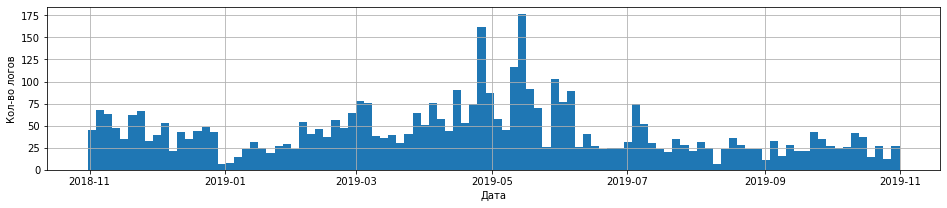

In [23]:
# Гистограмма количества логов по времения
plt.figure(figsize=(16, 3))
logs['date'].hist(bins=100)
plt.xlabel('Дата')
plt.ylabel('Кол-во логов');

Данные полные. В мае и июне наблюдается повышенное количество логов.

### Основные характеристики датасета 

Рассмотрим основные характеристики датасета.

In [24]:
customer_count = logs['customer_id'].nunique()
print('Всего', customer_count, 'покупателей/я')
orders_count = logs['order_id'].nunique()
print('Всего', orders_count, 'заказа/ов')
orders_per_customer = orders_count / customer_count
print('Среднее количество заказов на покупателя: {:.2f}'.format(orders_per_customer))
products_per_order = logs.groupby('order_id')['quantity'].sum().mean()
print('Среднее количество товаров в заказе {:.2f}'.format(products_per_order))

Всего 2279 покупателей/я
Всего 2552 заказа/ов
Среднее количество заказов на покупателя: 1.12
Среднее количество товаров в заказе 5.80


### Количество заказов на покупателя 

#### Распределение количества заказов на покупателя

Посмотрим на распределение количества заказов по покупателям.

In [25]:
orders_per_customer = logs.groupby(by = ['customer_id'])['order_id'].nunique()
orders_per_customer.sort_values(ascending=False)[:10]

customer_id
c971fb21-d54c-4134-938f-16b62ee86d3b    106
73d1cd35-5e5f-4629-8cf2-3fda829d4e58     17
b7b865ab-0735-407f-8d0c-31f74d2806cc      7
0184f535-b60a-4914-a982-231e3f615206      5
498f12a4-6a62-4725-8516-cf5dc9ab8a3a      4
e0535076-6270-4df2-8621-cb06264a94fa      4
bea7a833-2074-42db-bc49-4457abd3c930      4
d16fbc13-50a6-4dea-aafc-bc197aafc9e4      3
dfbcfde5-21de-4504-aff4-453e617d81c1      3
d02429ab-22e0-4ff2-9465-3082befde444      3
Name: order_id, dtype: int64

В датасете наблюдается несколько пользователей с аномально большим количеством заказов. Лидер - пользователь c971fb21-d54c-4134-938f-16b62ee86d3b со 106-ю заказами.

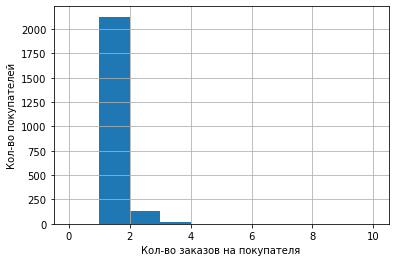

In [26]:
# диаграмма распределения
orders_per_customer.hist(bins=10, range=(0, 10))
plt.xlabel('Кол-во заказов на покупателя')
plt.ylabel('Кол-во покупателей');

Количество заказов на поупателя распределено в диапазоне от одного до 106. При этом основная масса покупателей сделала заказ только один заказ.

#### Распределение количества товаров в заказе

Посмотрим на распределение количества товаров по заказам.

In [27]:
product_per_order = logs.groupby(['order_id'])['quantity'].sum()
product_per_order.sort_values(ascending=False)[:10]

order_id
71743    1000
14833     900
71668     334
71478     300
14835     224
69289     200
68815     170
72845     160
70841     150
68831     140
Name: quantity, dtype: int64

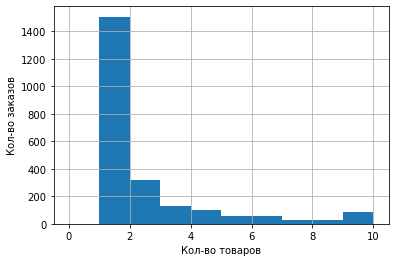

In [28]:
# диаграмма распределения
product_per_order.hist(bins=10, range=(0, 10))
plt.xlabel('Кол-во товаров')
plt.ylabel('Кол-во заказов');

Количество товаров в заказе распределено в диапазоне от одного до 1000.  У основной массы покупателей имеется лишь один товар в заказе. 

### Обработка аномальных значений 

#### Аномалии количества заказов на покупателя 

Посчитаем прецентили 95% и 99%.

In [29]:
orders_per_customer.quantile([0.95, 0.99])

0.95    2.0
0.99    3.0
Name: order_id, dtype: float64

Удалим покупателей с количеством заказов > 3.

In [30]:
customers_id_for_drop = list(orders_per_customer[orders_per_customer > 3].index)
logs = logs[~logs['customer_id'].isin(customers_id_for_drop)]
print('Суммарно удалено {:.1%}'.format(1-len(logs)/logs_count))

Суммарно удалено 4.7%


#### Аномалии количества товаров в заказе 

Посчитаем прецентили 95% и 99%.

In [31]:
product_per_order.quantile([0.95, 0.99])

0.95    20.0
0.99    60.0
Name: quantity, dtype: float64

Удалим покупателей с количеством товаров в заказе > 60.

In [32]:
logs = logs[~logs['customer_id']
            .isin(list(logs['customer_id'][logs['order_id']
            .isin(list(product_per_order[product_per_order > 60].index))]))]
print('Суммарно удалено {:.1%}'.format(1-len(logs)/logs_count))

Суммарно удалено 7.6%


Было удалена большая часть датасета. Примем гипотезу о том, что удалённые покупатели это оптовики. Таким образом, мы оставили только обычных потребителей и дальше будем анализировать только их. При необходимости можно рассмотреть и оптовых покупателей отдельно.

### Категоризация товаров 

Катеоризация сделана ручным способом на основе названий товаров. 

Ниже определена функция text_for_category():, которая принимает строку, разбивает весь текст на отдельные слова, приводит их к нормальной форме при помощи pymorphy2, выбрасывает все слова, длинна которых меньше 3-х символов.
[https://cloud.croc.ru/blog/about-technologies/keras-i-tensorflow-klassifikatsiya-teksta/]

In [33]:
morph = pymorphy2.MorphAnalyzer()

def text_for_category(text, place):
    # выделение нормальной формы и разбиение текста по словам
    text = ' '.join(morph.parse((word))[0].normal_form for word in text.split())
    # удаление слов длинной менее 3=-х символов 
    text = ' '.join(word for word in text.split() if len(word) > 3)
    return text.split()[place]

Применим функцию text_for_category() к каждому наименованию товара и запишем в датафрейм первое и второе слово наименования.

In [34]:
logs['product_first'] = logs.apply(lambda x: text_for_category(x['product'], 0), axis=1)
logs['product_second'] = logs.apply(lambda x: text_for_category(x['product'], 1), axis=1)

После этого выводим недублированные первые и вторые слова нименований и вручную собираем слова в словарь category_dict с выделением категорий.

In [35]:
logs_product_name = logs.drop_duplicates(subset=['product_second', 'product_first'])

In [36]:
logs_product_name.sample(5)

,customer_id,order_id,product,quantity,price,date,hour,month,product_first,product_second
470,1ac82730-7e1b-4581-9b99-59a9f513b0c9,68860,муляж красное яблоко мини полиуретан d-6 см,6,22.0,2018-11-05 12:00:00,12,11,муляж,красный
1856,6103dd99-546e-4800-a283-1cd5fd7a3958,69595,доска разделочная alparaisa стеклянная завтрак...,1,149.0,2018-12-25 20:00:00,20,12,доска,разделочный
1618,55a2b456-f4c4-4fb9-9a8d-bbf2a5d6e16c,72606,соковыжималка для цитрусовых pasabahce ots1314...,1,202.0,2019-09-12 13:00:00,13,9,соковыжималка,цитрусовый
1820,5fe1274b-74ac-4a16-bde7-48e28879b2c6,72355,"мешок для деликатной стирки 50х70см, attribute...",1,104.0,2019-08-20 18:00:00,18,8,мешок,деликатный
3897,d0a58e7e-0d2a-45f0-bdd3-e7a2aa8d7454,69209,"таз пластмассовый 18,0 л пищевой (иж), 1404047",1,194.0,2018-12-04 19:00:00,19,12,пластмассовый,"18,0"


В ходе составления словаря выделено 9 категорий:
- 'Искусственные растения'
- 'Растения'
- 'Хозяйственные принадлежности' - товары для активных действий по дому (щётки, тазики, сумки).
- 'Ванная и туалет'
- 'Чистящие средства'
- 'Дом' - вещи для обеспечения уюта в доме, как правило статичные (постельное бельё, мебель, декор).
- 'Кухня'
- 'Строительство'
- 'Другое' (те товары, которые не вошли в категорию выше)

In [37]:
# словарь с категориями
category_dict = {
    
    'Искусственные растения': [
                'муляж', 'искусственный', 'декоративный'
                ],
    
    'Растения': [
                'адиантум', 'азалия', 'аквилегия', 'алиссума', 'алоэ', 'амариллис', 'анемон', 'антуриум', 'аптения', 'арбуз',
                 'артемизия', 'аспарагус', 'бадан', 'базилик', 'бакоп', 'бальзамин', 'бегония',
                 'вербена', 'вероника', 'виноград', 'газаний', 'гайлардия', 'гардения', 'гвоздик',
                 'георгин', 'герань', 'гербер', 'гиацинт', 'гимнокалициум', 'гиностемма',
                 'гипсофил', 'глоксиния', 'горох', 'гортензия', 'декабрист', 'джункус', 'драцена', 'душица',
                 'дыня', 'дендробиум', 'ель', 'замиокулькас', 'зверобой', 'зелень', 'земляника', 'импатиенс',
                 'каландив', 'капуста', 'калатея', 'калибрахоа', 'калла', 'камнеломка', 'кампанула',
                 'кашпо', 'кипарисовик', 'клен', 'кодонант', 'колокольчик', 'комнатный', 'коник',
                 'кориандр', 'косметь', 'котовник', 'крассула', 'крокус', 'лаванда', 'лавр', 'лазурь'
                 'лантан', 'лапчатка', 'лилейникнуть', 'литопс', 'лобелия', 'маттиола', 'мединилла',
                 'мелисса', 'мирт', 'мимоза', 'молодило', 'монард', 'муррайя', 'мускари', 'мятый',
                 'настурция', 'незабудка', 'нивянник', 'нолин', 'овсянница', 'огурец', 'осина', 'папоротник', 'патиссон',
                 'пуансеттие', 'пахир', 'пеларгония', 'пеперомия', 'петрушка', 'петуния', 'платикодон', 'подсолнечник',
                 'порей', 'примула', 'пуансетие', 'радермахер', 'ранункулус', 'рассада',
                 'растение', 'роза', 'розмарин', 'рудбекия', 'рукол', 'сальвия', 'седума',
                 'синнингий', "спатифиллум", 'смолёвка', 'совок', 'суккулента', 'сциндапсус', 'табак', 'томат', 'томата',
                 'тимьян', 'трава', 'тюльпан', 'тюльпаны', 'укроп', 'фатсия', 'фиалка', 'фикус', 'флокс', 'фуксия',
                 'хамедорей', 'хлорофитум', 'хост', 'хризантема', 'хризолидокарпус', 'цветок',
                 'целозия', 'цикламен', 'цинния', 'циперус', 'цитрофортунелла', 'чабер', 'фаленопсис',
                 'шеффлера', 'шпагат', 'эхеверие', 'эвкалипт', 'энотера', 'эпипремнум', 'эхеверие'
                 'эхинокактус', 'юкка', 'ясколка'
                ],
    
    'Хозяйственные принадлежности':[
                                     'белье', 'ведро', 'веник', 'вешалка-перекладина', 'гладильный', 'зажигалка',
                                     'ключница', 'корзинка', 'коробка', 'линейка', 'насадка-моп', 'насадка-отжим',
                                     'окномойка', 'подкладка', 'прищепка', 'пылесос', 'пьезозажигалка', 'скребок',
                                     'сумка', 'сумка-тележка', 'таз', 'тележка', 'ткань', 'тряпка',
                                     'тряпкодержатель', 'урна-пепельница', 'утюг', 'чехол', 'швабра', 'шнур'
                                     'щетка', 'щетка-сметка'
                                    ],
    
    'Ванная и туалет': [
                         'ванна', 'ванная', 'вантуз', 'вешалка-стойка', 'дозатор', 'зубной', 'корыто', 'кофр',
                         'мочалка', 'мыло', 'мыльница', 'пена', 'полотенце', 'стиральный', 'сушилка',
                         'таз', 'туалет', 'туалетный', 'унитазный', 'халат', 'ерш'
                        ],
    
    'Чистящие средства': [
                          'биопорошок', 'концентрат', 'крем', 'мытье', 'отбеливатель', 'порошок',
                          'средство', 'стирка', 'чистка', 'удаление'
                         ],
    'Дом': [
             'вакуумный', 'вешалка', 'вешалка-плечики', 'карниз', 'коврик', 'ковёр', 'комод', 'корзина', 'крючок',
             'мебельный', 'наволочка', 'нарезка', 'обувница-3', 'обувь', 'одеяло', 'перчатка', 'покрывало', 'плед', 'плечики',
             'простыня', 'пододеяльник', 'подушка', 'стеллаж', 'термометр', 'штора', 'этажерка', 'ящик'
           ],
    
    'Кухня': [  
                 'webber', 'банка', 'банк', 'бензин', 'бидон', 'блюдо', 'блюдце', 'бокал', 'венчик', 
                 'весы', 'вантуз', 'вилка', 'вкладыш', 'доска', 'емкость',
                 'кастрюля', 'ковш', 'контейнер', 'котел', 'кофе', 'кружка', 'крышка', 'кувшинвилка', 'ложка', 'лопатка',
                 'масленка', 'миксер', 'мини-сковорода', 'миска', 'мука', 'мусор', 'мусорный',
                 'нож', 'ножеточка', 'овощ', 'овощеварка', 'овощечистка', 'отделитель',
                 'подрукавник', 'половник', 'противень', 'салатник', 'салфетка', 'салфетница',
                 'сахарница', 'сито', 'скалка', 'скатерть', 'сковорода', 'соковыжималка', 'соль',
                 'сотейник', 'стакан', 'столовый', 'тарелка', 'термос', 'tepмокружка', "термокружка", 
                 'термостакан', 'толкушка', 'тортница', 'тёрка', 'урна', 'форма', 'фужер', 'хлебница', 
                 'чайный', 'чайник', 'чеснок', 'электроштопор'
            ],
    'Строительство': [
                         'блок', 'вентиляционный', 'веревка', 'завертка', 'измерительный', 'крепеж',
                         'лестница-стремянка', 'мешок', 'нитрид', 'петля-стрела', 'петлить', 'полировка', 'пробка',
                         'полка', 'пружина', 'ручка-скоба', 'сварка', 'сверло', 'стремянка', 'стремянка-табурет',
                         'стяжка', 'уголок', 'фиксатор-шар', 'шпингалет'
                     ],
}

Ниже определена функция, которая присваивает категорию на основе пересечения слов наименования товара со словами в словаре.

In [38]:
def set_product_category(text):
    category_product = ''
    # выделение нормальной формы
    text = ' '.join(morph.parse((word))[0].normal_form for word in text.split())
    # цикл пробегающий по словам в наименовании и по словарю
    for word in text.split():
        if category_product == '':
            for category in category_dict:
                if word in category_dict[category]:
                    category_product = category
                    # присваивание категории
                    return category_product 
    return 'Другое'           

In [39]:
# применяем функцию
logs['category'] = logs.apply(lambda x: set_product_category(x['product']), axis=1)

In [40]:
logs.sample(5)

,customer_id,order_id,product,quantity,price,date,hour,month,product_first,product_second,category
4460,ea741fdc-4883-4fc1-a34e-a8bcf8dc6cbb,69608,"тарелка суповая luminarc океан эклипс 20,5 см ...",30,82.0,2018-12-26 10:00:00,10,12,тарелка,суповой,Кухня
3919,d16fbc13-50a6-4dea-aafc-bc197aafc9e4,14588,пеларгония розебудная prins nikolai укорененны...,1,135.0,2019-03-25 11:00:00,11,3,пеларгония,розебудный,Растения
463,1a725b7e-f09b-4bc1-8579-b9893adb91f8,14729,петуния sweetunia rose gem розовая с прожилкам...,1,90.0,2019-05-07 11:00:00,11,5,петуния,sweetunia,Растения
3227,b0f19fc0-a432-4d43-b476-e02ac01a5b7b,71988,зверобой продырявленный оптимист d- 12-13 см,1,187.0,2019-07-15 12:00:00,12,7,зверобой,продырявить,Растения
3527,c0b74fe0-883e-46c6-91eb-b872c5db7c70,72896,коврик интерьерный для кухни la bruschetta из ...,1,638.0,2019-10-08 17:00:00,17,10,коврик,интерьерный,Дом


- Определена функция которая принимает строку, разбивает наименование товаров на отдельные слова, приводит их к нормальной форме при помощи pymorphy2 , выбрасывает все слова, длинна которых меньше 3-х символов.
- Собран словарь для категоризации.
- Определена функция, которая присваивает категорию на основе пересечения слов наименования товара со словами в словаре.
- Категоризация успешно проведена.

### Анализ категорий 

####  Популярность категорий

Посчитаем сколько товаров было заказвно в каждой категории.

In [41]:
logs.groupby('category')['quantity'].sum().sort_values(ascending=False)

category
Растения                        3838
Кухня                           1208
Искусственные растения          1196
Хозяйственные принадлежности    1109
Дом                             1030
Ванная и туалет                  538
Другое                           309
Строительство                    262
Чистящие средства                 26
Name: quantity, dtype: int64

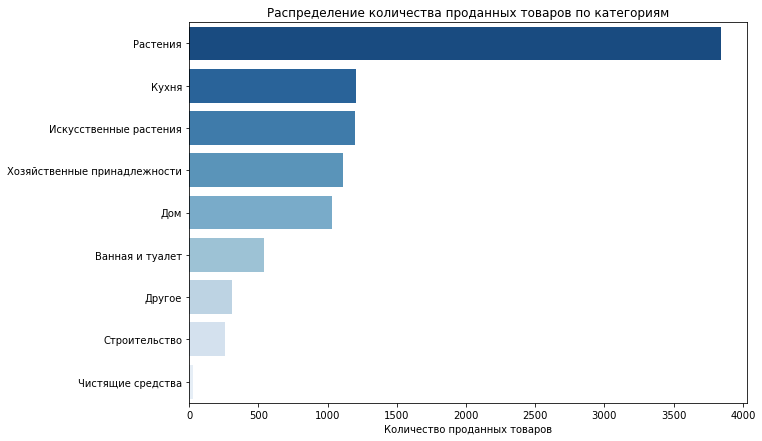

In [42]:
plt.figure(figsize=(10, 7))
g = sns.barplot(logs.groupby('category')['quantity'].sum().sort_values(ascending=False).values, 
                logs.groupby('category')['quantity'].sum().sort_values(ascending=False).index, palette='Blues_r')
g.set_title('Распределение количества проданных товаров по категориям')
g.set_xlabel('Количество проданных товаров')
g.set_ylabel('');

Наиболее популярными категориями оказались "Растения".

#### Анализ выручки по категориям

Посмотрим какие категории приносят наибольшую суммарную выручку.

In [43]:
logs['revenue'] = logs['price'] * logs['quantity']
logs.groupby('category')['revenue'].sum().sort_values(ascending=False).map('P{: ,.0f}'.format)

category
Хозяйственные принадлежности    P 1,198,079
Растения                          P 523,137
Дом                               P 429,115
Кухня                             P 353,946
Ванная и туалет                   P 341,855
Строительство                     P 225,178
Другое                             P 81,361
Искусственные растения             P 63,920
Чистящие средства                   P 3,643
Name: revenue, dtype: object

Также посмотрим на среднуюю выручку.

In [44]:
logs.groupby('category')['revenue'].mean().sort_values(ascending=False).map('P{: ,.2f}'.format)

category
Строительство                   P 2,680.69
Хозяйственные принадлежности    P 2,058.55
Дом                             P 1,430.38
Ванная и туалет                 P 1,203.71
Кухня                           P 1,053.41
Другое                            P 774.87
Искусственные растения            P 318.01
Чистящие средства                 P 260.21
Растения                          P 244.57
Name: revenue, dtype: object

- Несмотря на популярность растений наибольшу выручку принесли хозяйственные товары;
- Наибольшая средняя выручка за товар характерна для категории "Строительство" и "Хозяйственные принадлежности".

#### Анализ средней цены товара по категориям

In [45]:
logs.groupby('category')['price'].mean().sort_values(ascending=False).map('P{: ,.2f}'.format)

category
Строительство                   P 1,740.04
Хозяйственные принадлежности    P 1,485.04
Ванная и туалет                   P 946.64
Дом                               P 805.32
Кухня                             P 532.32
Другое                            P 506.33
Чистящие средства                 P 178.21
Растения                          P 147.42
Искусственные растения             P 72.27
Name: price, dtype: object

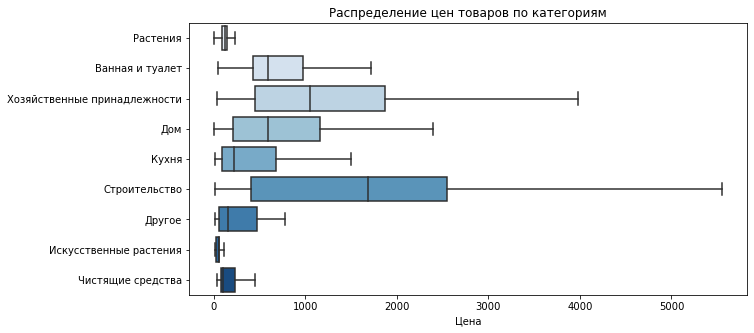

In [46]:
# построеие графика ящик с усами
plt.figure(figsize=(10, 5))
g = sns.boxplot(x="price", y="category",
                 data=logs, palette='Blues', orient='h', showfliers = False)
g.set_title('Распределение цен товаров по категориям')
g.set_xlabel('Цена')
g.set_ylabel('');

- Наиболее дорогие товары характерны для категорий строительство и хоз. принадлежности;
- Самые дешёвые товары это растения и искусственные растения.

#### Анализ месячной сезонности 

Рассмотрим месячную сезонность товаров по категориям. Ниже представлена гистограмма показывающая помесячное количество логов, разделённых на категории.

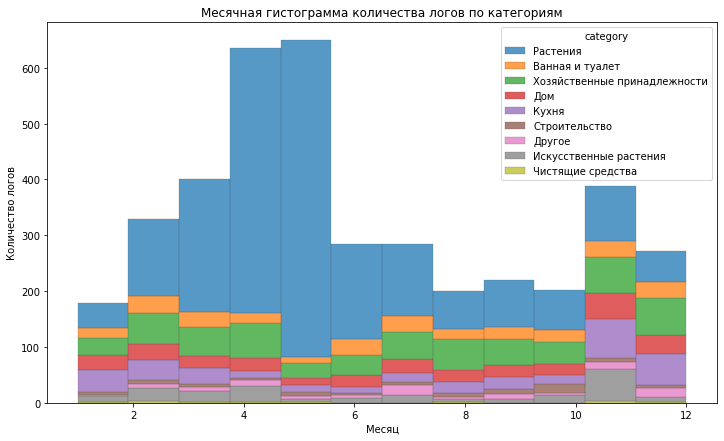

In [47]:
# месячная гистограмма количества логов по категориям
plt.figure(figsize=(12, 7))

ax = sns.histplot(
    logs,
    x="month", hue="category",
    multiple="stack",
    palette="tab10",
    edgecolor=".3",
    linewidth=.2, 
    bins=12
)
ax.set_title('Месячная гистограмма количества логов по категориям')
ax.set_xlabel('Месяц')
ax.set_ylabel('Количество логов');
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1.05, 1), title='Категории');

Также построим помесячные круговые диаграммы, характеризующие общее количество заказанных товаров по категориям.

In [48]:
# функция для построения круговых диаграмм
def pie(column, column_value, fig_x, fig_y):
    fig, axs = plt.subplots(int(mth.ceil(logs[column].max()/2)), 2, figsize=(fig_x, fig_y))
    for value, ax in zip(range(logs[column].min(), logs[column].max()+1), axs.ravel()):
        data = logs[logs[column] == value].groupby('category')[column_value].sum().sort_values(ascending=False)
        data_sum = data.sum()
        # лимит занчения характеристики для перехода в категорию "остальное" на диаграмме
        limit_value = data_sum * 0.10
        data = data.drop(data[data < limit_value].index)
        data["Остальное"] = data_sum - data.sum()
        ax.pie(data.sort_values(ascending=False).values, labels = data.index)
        ax.set_title(value)

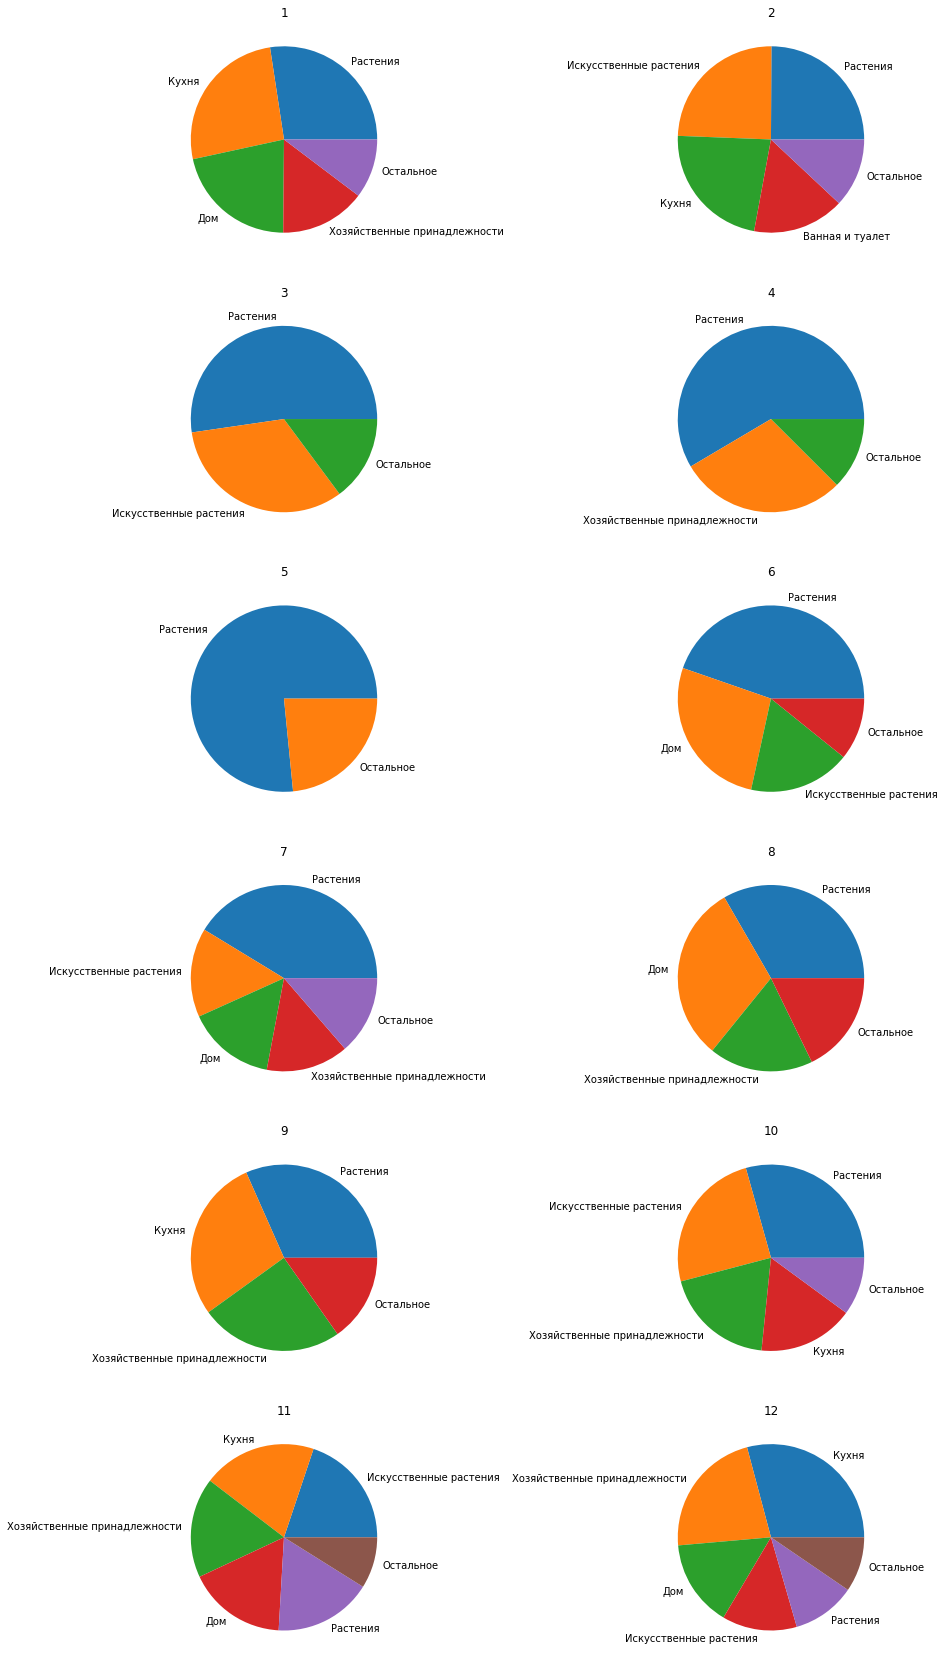

In [49]:
pie('month', 'quantity', 16, 30)

- Наблюдается повышенное количество покупок в ноябре и декабре (это конец 2018 года).
- Популярность растений выше обычного с марта по май - особенно в мае. Скорее всего интерес проявляют дачники, покупая рассаду. 
- Заинтересованность искусственными растениями проявляется в октябре и ноябре, что может быть связано с подготовкой к новому году.
- В декабре и январе немного увеличиваются продажи кухонных, хозяйственных принадлежностей и товаров категории "Дом" что может быть связано с новогодними праздниками. Домашняя утварь - распространённый подарок.
- В остальных категориях месячная сезонность не проявляется.

#### Анализ часовой сезонности  

Рассмотрим часовую сезонность товаров по категориям. Ниже представлена гистограмма показывающая почасовое количество логов, разделённых на категории.

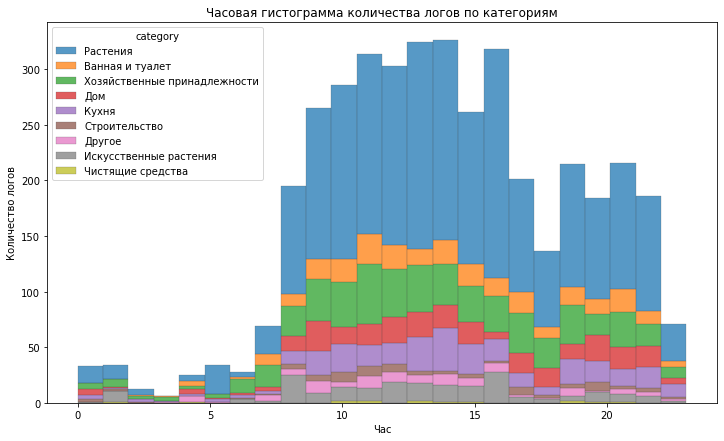

In [50]:
plt.figure(figsize=(12, 7))
ax = sns.histplot(
    logs,
    x=logs["date"].dt.hour, hue="category",
    multiple="stack",
    palette="tab10",
    edgecolor=".3",
    linewidth=.2, 
    bins=24
)
ax.set_title('Часовая гистограмма количества логов по категориям')
ax.set_xlabel('Час')
ax.set_ylabel('Количество логов');

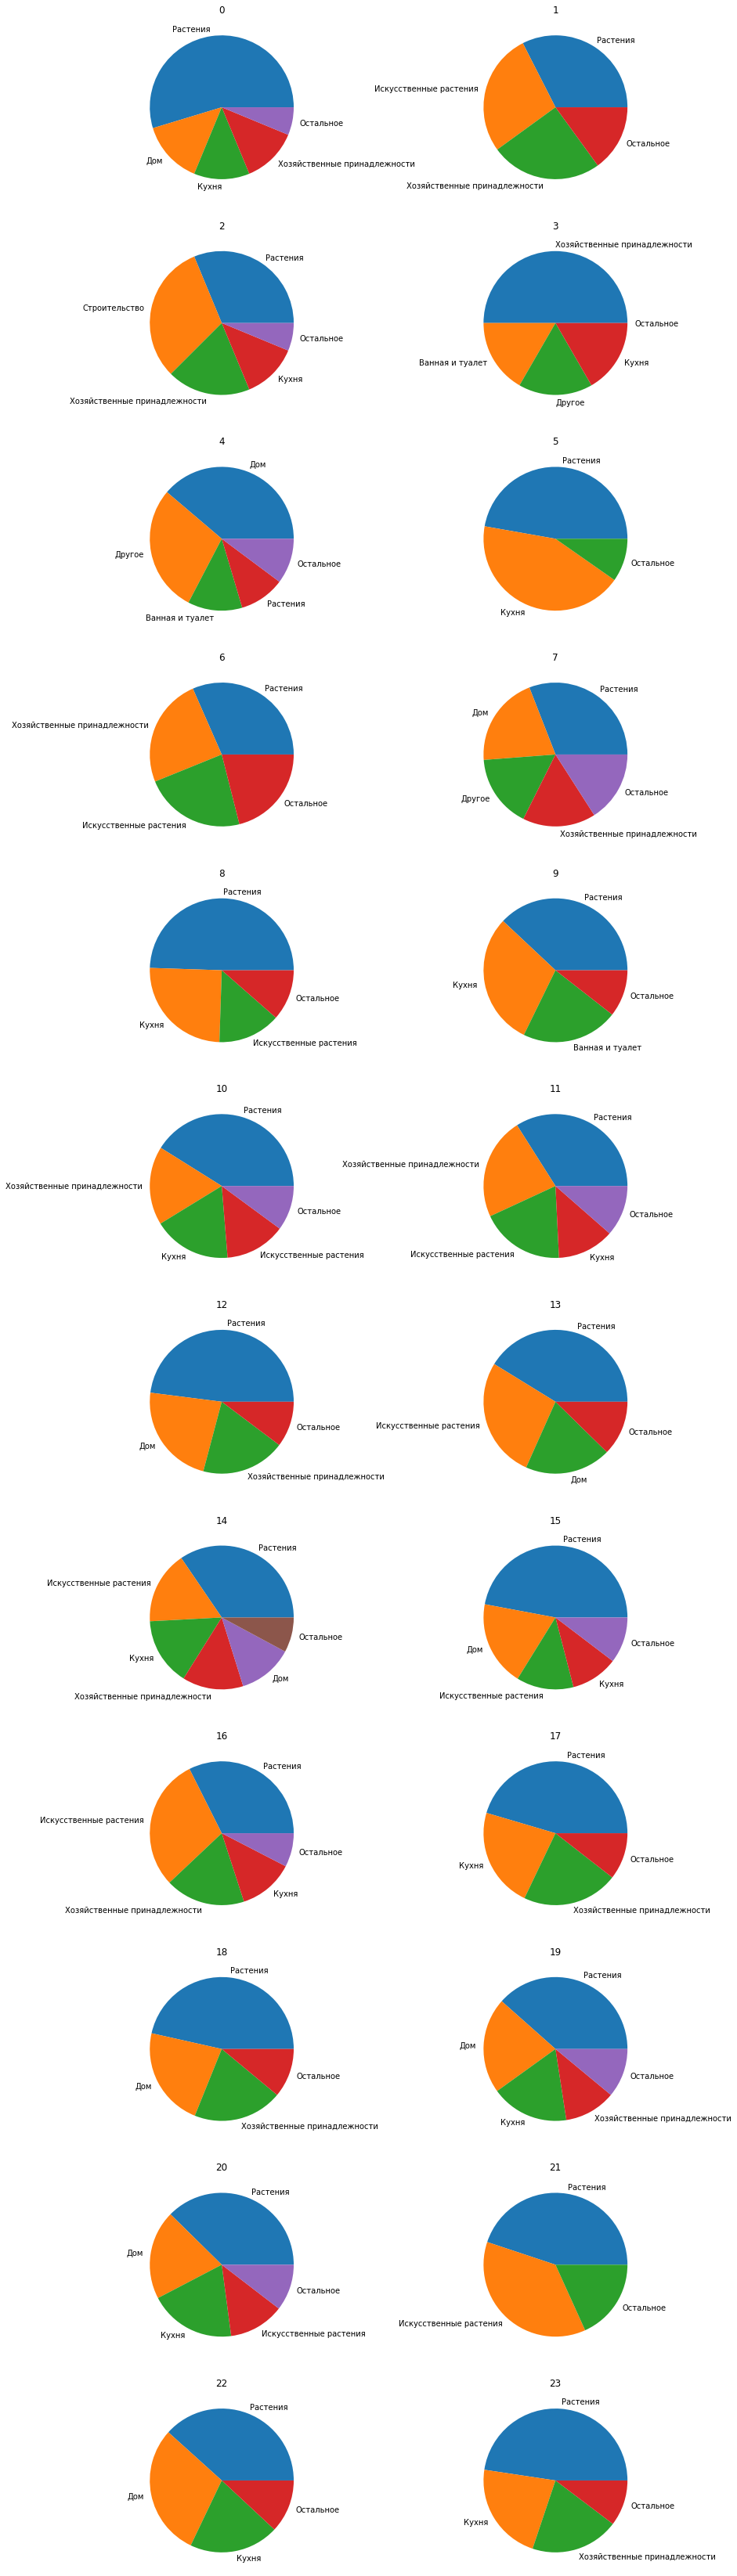

In [51]:
pie('hour', 'quantity', 14, 60)

- активность покупателей возрастает с 7 утра и достигает в 11 часов утра "плато", которое длится до 17 часов;
- наблюдается заметный провал активности в 18 часов, и это может быть связано с тем, что потребители находятся на пути с работы домой;
- после 18 00 клиенты проявляют меньшую активность - дома нужно отдыхать=);
- в утренние часы, кроме растений популярны хоз. принадлежности;
- часовая сезонность в остальных категориях не обнаружилась.

#### Зависимость выручки заказа от количества товаров

In [52]:
orders = logs.groupby('order_id')[['quantity', 'price', 'revenue']].sum()

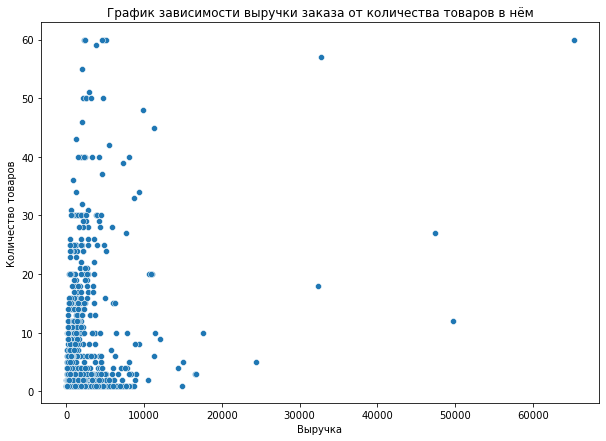

In [53]:
# построение графика
plt.figure(figsize=(10, 7))
ax = sns.scatterplot(data=orders, x='revenue',
                    y='quantity')
ax.set_title('График зависимости выручки заказа от количества товаров в нём')
ax.set_xlabel('Выручка')
ax.set_ylabel('Количество товаров');

Чёткой зависимости между количеством товаров и выручкой заказа не наблюдается.

## Проверка статистических гипотез 

### Проверка сезонности доли товаров категории "Растения" 

Проверим статистическую значимость различия доли купленных товаров между периодом за март-июнь с остальными месяцам.

**Сформулируем гипотезы:**

- **H0** - *доля купленных товаров категории Растения с марта по май **>** доли купленных товаров с ноября по февраль и с июня по октябрь в объединении.*

- **H1** - *доля купленных товаров категории Растения с марта по май **<=** доли купленных товаров с ноября по февраль и с июня по октябрь в объединении.*

Сформируем ряды данных для статистического теста. В первую группу войдут купленные товары с марта по май, а во вторую в остальные месяцы.

In [54]:
first_group_plants = logs[(logs['month'] >= 3) & (logs['month'] <= 5) & (logs['category'] == 'Растения')]['quantity'].sum()
second_group_plants = logs[((logs['month'] >= 6) | (logs['month'] <= 2))  & (logs['category'] == 'Растения')]['quantity'].sum()

first_group = logs[(logs['month'] >= 3) & (logs['month'] <= 5)]['quantity'].sum()
second_group = logs[(logs['month'] >= 6) | (logs['month'] <= 2)]['quantity'].sum()

In [55]:
print('Доля категории "Растения" первой группы: {:.0%}'.format(first_group_plants / first_group))
print('Доля категории "Растения" второй группы: {:.0%}'.format(second_group_plants / second_group))

Доля категории "Растения" первой группы: 63%
Доля категории "Растения" второй группы: 27%


In [56]:
alpha = .05 # критический уровень статистической значимости

# пропорция успехов в первой группе:
p1 = first_group_plants/first_group

# пропорция успехов во второй группе:
p2 = second_group_plants/second_group

# пропорция успехов в комбинированном датасете:
p_combined = (first_group_plants + second_group_plants) / (first_group + second_group)

#разница пропорций в датасетах
difference = p1 - p2

#считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/first_group + 1/second_group))

#задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value)))
print('p-значение: ', p_value)

# тест односторонний вправо:
# НЕ отвергаем гипотезу только тогда, когда выборочное среднее значимо больше предполагаемого значения
if (p_value < alpha) and (p1 > p2):
    print('Не отвергаем нулевую гипотезу',
         "\nДоля купленных товаров категории Растения с марта по май >",
          "\nдоли купленных товаров с ноября по февраль и с июня по октябрь в объединении.")
else:
    print('Отвергаем нулевую гипотезу',
         "\nДоля купленных товаров категории Растения с марта по май <=",
          "\nдоли купленных товаров с ноября по февраль и с июня по октябрь в объединении.")

p-значение:  0.0
Не отвергаем нулевую гипотезу 
Доля купленных товаров категории Растения с марта по май > 
доли купленных товаров с ноября по февраль и с июня по октябрь в объединении.


### Проверка сезонности средней выручки товаров в категории "Растения"

Проверим статистическую значимость различия средней выручки товаров категории растения между периодом за март-июнь (первая группа) с остальными месяцам (вторая группа).

**Сформулируем гипотезы:**

- **H0** - *средняя выручка купленных товаров категории Растения с марта по май (первая группа) **>** средней выручки купленных товаров с ноября по февраль и с июня по октябрь в объединении (вторая группа).*

- **H1** - *средняя выручка купленных товаров категории Растения с марта по май (первая группа) **<=** средней выручки купленных товаров с ноября по февраль и с июня по октябрь в объединении (вторая группа).*

В данном разделе будет применен односторонний статистический t-test на проверку равенства среднего генеральных совокупностей.

Сформируем ряды данных для статистического теста.

In [57]:
# выручка категории Растения с марта по май
first_group = list(logs[(logs['month'] >= 3) & (logs['month'] <= 5) & (logs['category'] == 'Растения')]['revenue'])

# выручка категории Растения за оставшиеся месяцы
second_group = list(logs[((logs['month'] >= 6) | (logs['month'] <= 2))  & (logs['category'] == 'Растения')]['revenue'])

In [58]:
print('Среднее первой группы: {:.0f}'.format(np.mean(first_group)))
print('Среднее второй группы: {:.0f}'.format(np.mean(second_group)))
print('Дисперсия первой группы: {: ,.0f}'.format(np.var(first_group)))
print('Дисперсия второй группы: {: ,.0f}'.format(np.var(second_group)))

Среднее первой группы: 207
Среднее второй группы: 300
Дисперсия первой группы:  137,595
Дисперсия второй группы:  625,035


Несмотря на большую долю продажи товаров в марте-июне, средняя выручка заказов за этот период меньше. 
Дисперсии в группах различаются сильно, и это нужно учитывать, поэтому в статтистическом тесте прописывем `equal_var = False`.

In [59]:
# статистический t-test тест

alpha = .05

results = st.ttest_ind(
                        first_group,
                        second_group,
                        equal_var = False
                        )
# ваш код: проверьте гипотезу о равенстве средних двух независимых совокупностей

print('p-значение:', results.pvalue/2)

if (results.pvalue < alpha) and (np.mean(first_group) > np.mean(second_group)):
    print("Не получилось отвергнуть нулевую гипотезу",
         "\nСредняя выручка купленных товаров категории Растения с марта по май (первая группа) >",
          "\nсредней выручки купленных товаров с ноября по февраль и с июля по октябрь в объединении (вторая группа).")
else:
    print("Отвергаем нулевую гипотезу",
         "\nСредняя выручка купленных товаров категории Растения с марта по июнь (первая группа) <=",
          "\nсредней выручки купленных товаров с ноября по февраль и с июня по октябрь в объединении (вторая группа).")

p-значение: 0.0006503105574927675
Отвергаем нулевую гипотезу 
Средняя выручка купленных товаров категории Растения с марта по июнь (первая группа) <= 
средней выручки купленных товаров с ноября по февраль и с июня по октябрь в объединении (вторая группа).


Средняя выручка купленных товаров категории Растения с марта по июнь (первая группа) **<=** средней выручки купленных товаров с ноября по апрель и с июля по октябрь в объеднении (вторая группа) несмотря на увеличение доли количества заказанных товаров в первой группе. 

Давайте подумаем почему так могло произойти. Скорее, всего снижение выручки за сезон март-июнь произошло из-за увеличения покупок товаров дешевой подкатегории. При категоризации данных достаточно часто в наиеновании товара попадалось слово "Рассада", которая в итоге была внесена в категорию "Растения". Рассада, как правило, менее дорогая, чем уже повзрослевшее растение. Проверим эту гипотезу.

Отфильтруем датафрейм по категории "Растения". Именно там вся рассада.

In [60]:
logs_plants= logs[logs['category'] == 'Растения']

Категаризируем её с помощтю функции set_product_category_rassada. Она сделеана по тому же принципу, что и ранее когда производилась общая категоризация.

In [61]:
def set_product_category_rassada(text):
    # выделение нормальной формы
    text = ' '.join(morph.parse((word))[0].normal_form for word in text.split())
    # цикл пробегающий по словам в наименовании и по словарю
    for word in text.split():
        if word == 'рассада':
            return 'Рассада'
    return 'Растения'

In [62]:
# применяем функцию
logs_plants['category'] = logs_plants.apply(lambda x: set_product_category_rassada(x['product']), axis=1)

Построим гистограмму распределения с выделением подкатегории "Рассада".

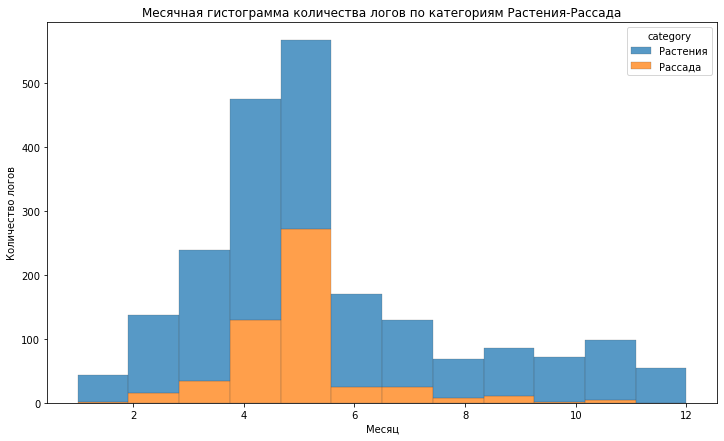

In [63]:
# месячная гистограмма количества логов по категориям растения-рассада
plt.figure(figsize=(12, 7))
ax = sns.histplot(
    logs_plants,
    x="month", hue="category",
    multiple="stack",
    palette="tab10",
    edgecolor=".3",
    linewidth=.2, 
    bins=12
);
ax.set_title('Месячная гистограмма количества логов по категориям Растения-Рассада')
ax.set_xlabel('Месяц')
ax.set_ylabel('Количество логов');
#sns.move_legend(ax, "upper left", title='Категории');

Действительно, в этот сезон в разы возросли покупки рассады. Правда только за апрель и май.

Рассмотрим средние цены подкатегорий.

In [64]:
logs_plants.groupby('category')['revenue'].mean().map('P{: ,.0f}'.format)

category
Рассада     P 178
Растения    P 267
Name: revenue, dtype: object

Рассада действительно значительно дешевле.

###  Заказы с одним товаром и несколькими

Проверим статистическую значимость различия средней выручки заказов с одним товаром со средней выручки заказов, в которых товаров больше одного.

**Сформулируем гипотезы:**

- **H0** - *средняя выручка заказов с одним товаром **>** средней выручки заказов, в которых товаров больше одного.*

- **H1** - *средняя выручка заказов с одним товаром **<** средней выручки заказов, в которых товаров больше одного.*

- **H2** - *средняя выручка заказов с одним товаром **=** средней выручки заказов, в которых товаров больше одного.*

В данном разделе будет применен статистический t-test на проверку равенства среднего генеральных совокупностей.

Сформируем ряды данных для статистического теста.

In [65]:
orders_sum = logs.groupby('order_id')[['quantity', 'revenue']].sum().reset_index()
order_one = list(orders_sum[orders_sum['quantity'] == 1]['revenue'])
order_more = list(orders_sum[orders_sum['quantity'] > 1]['revenue'])

In [66]:
print('Среднее группы с одним заказом: {:.0f}'.format(np.mean(order_one)))
print('Среднее группы с заказами > 1: {:.0f}'.format(np.mean(order_more)))
print('Дисперсия группы с одним заказом: {: ,.0f}'.format(np.var(order_one)))
print('Дисперсия группы с заказами > 1: {: ,.0f}'.format(np.var(order_more)))

Среднее группы с одним заказом: 1057
Среднее группы с заказами > 1: 1778
Дисперсия группы с одним заказом:  1,871,778
Дисперсия группы с заказами > 1:  15,451,230


In [67]:
alpha = .05

results = st.ttest_ind(
                        order_one,
                        order_more,
                        equal_var=False
                        )
# ваш код: проверьте гипотезу о равенстве средних двух независимых совокупностей

print('p-значение:', results.pvalue/2)

if (results.pvalue < alpha) and (np.mean(order_one) > np.mean(order_more)):
    print("Отвергаем первую и вторую гипотезы",
         "\nCредняя выручка заказов с одним товаром > средней выручки заказов, в которых товаров больше одного.")
elif (results.pvalue < alpha) and (np.mean(order_one) < np.mean(order_more)):
    print("Отвергаем нулевую и вторую гипотезы",
          "\nCредняя выручка заказов с одним товаром < средней выручки заказов, в которых товаров больше одного.")
else:
    print("Отвергаем нулевую и первую гипотезы",
         "\nCредняя выручка заказов с одним товаром = средней выручки заказов, в которых товаров больше одного.")

p-значение: 2.3408324388386094e-08
Отвергаем нулевую и вторую гипотезы 
Cредняя выручка заказов с одним товаром < средней выручки заказов, в которых товаров больше одного.


Чёткой зависимости цены заказа от количества товаров нет, однако, средняя выручка с несколькими товарами в заказе всё же выше.

## Выводы 

**Обзор данных:**
- все столбцы присутствуют;
- необходимо обработать формат даты;
- в таблице 6737 логов.

**Предобработка данных:**
- изменён тип данных столбца с датами;
- добавлены столбцы с месяцами и часами с целью дальнейшего анализа сезонности.

**Исследовательский анализ данных:**
- анализ полноты данных:
    - данные собраны с 2018-10-01 00:00:00 по 2019-10-31 16:00:00;
    - данные полные;
    - в мае и июне наблюдается две волны всплеска количества логов;
    - удалены логи за октябрь 2018.
- исключение выдающихся значений:
    - суммарно было удалено 7.6% логов. Было принято, что удалённые покупатели это оптовики. Таким образом, для анализа остались только обычные потребители.
- категоризация товаров:
    - 'Искусственные растения'
    - 'Растения'
    - 'Хозяйственные принадлежности' - товары для активных действий по дому (щётки, тазики, сумки).
    - 'Ванная и туалет'
    - 'Чистящие средства'
    - 'Дом' - вещи для обеспечения уюта в доме, как правило статичные (постельное бельё, мебель, декор).
    - 'Кухня'
    - 'Строительство'
    - 'Другое' (те товары, которые не вошли в категорию выше)
- изучение распределения количества товаров по заказам и покупателям:
    - всего 2279 покупателей/я;
    - всего 2552 заказа/ов;
    - среднее количество заказов на покупателя: 1.12;
    - среднее количество товаров в заказе 5.80;
    - наиболее популярными категориями оказались "Растения", "Кухня", "Искусственные растения".
- анализ выручки каждой категории:
    - несмотря на популярность растений наибольшую выручку принесли хозяйственные товары;
    - наибольшая средняя выручка характерна для категории "Строительство" и "Хозяйственные принадлежности";
    - наиболее дорогие товары характерны для категорий строительство и хоз. принадлежности;
    - самые дешёвые товары это растения и искусственные растения;
    - чёткой зависимости между количеством товаров и выручкой заказа не наблюдается.
- анализ сезонности:
    - месячная сезонность:
        - наблюдается повышенное количество покупок в ноябре и декабре;
        - популярность растений выше обычного с марта по май - особенно в мае. Скорее всего интерес проявляют дачники, покупая рассаду;
        - заинтересованность искуственными растениями проявляется в октябре и ноябре, что может быть связано с подготовкой к новому году;
        - в декабре и январе немного увеличиваются продажи кухонных, хозяйственных принадлежностей и товаров категории "Дом" что может быть связано с новогодними праздниками;
        - в остальных категориях месячная сезонность не проявляется;
    - часовая сезонность:
        - активность покупателей возрастает с 7 утра и достигает в 11 часов утра "плато", которое длится до 17 часов;
        - наблюдается заметный провал активности в 18 часов, и это может быть связано с тем, что потребители находятся на пути с работы домой;
        - после 18 00 клиенты проявляют меньшую активность;
        - часовая сезонность в категориях не обнаружилась.    

    
**Статистические гипотезы:**
- Проверка сезонности доли товаров в популярной категории:
    - Доля купленных товаров категории Растения с марта по май > доли купленных товаров с ноября по февраль и с июня по октябрь в объединении.
- Проверка сезонности средней выручки товаров в популярной категории:
    - Средняя выручка купленных товаров категории Растения с марта по июнь (первая группа) <= средней выручки купленных товаров с ноября по апрель и с июля по октябрь в объединении (вторая группа) несмотря на увеличение доли количества заказанных товаров в первой группе.
    - Выделена подкатегория "Рассада", которая набирает популярность в апреле и мае и из-за дешевизны товаров  уменьшает среднюю выручку всей категории "Растения".
- Проверка статистической значимости различия средней выручки заказов с одним товаром со средней выручки заказов, в которых товаров больше одного:
    - Cредняя выручка заказов с одним товаром < средней выручки заказов, в которых товаров больше одного.
    - Чёткой зависимости цены заказа от количества товаров нет, однако, средняя выручка с несколькими товарами в заказе всё же выше.